<a href="https://colab.research.google.com/github/vihaannnn/AI-Allignment-Research/blob/master/Submissions/Adverserial_Patch_%2B_Perturbed_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Given below are the cells that perform an Adverserial Patch attack**

**Please make sure you load the imagenet_classes.txt file and the volcano.png file, to ensure the correct working of the Perturbation attck**

This Code was written with reference too -

Perplexity AI

Google Tutorials

https://github.com/Lasagne/Recipes/blob/master/examples/resnet50/imagenet_classes.txt
https://vitalflux.com/pytorch-load-predict-pretrained-resnet-model/

https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks.ipynb

In [24]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-24-1e6e32f09a96>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In [25]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

In [26]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [27]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [28]:
#Function to place the patch randomly on the image
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [29]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [30]:
#Code to Validate the workings of our patch
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [31]:
#Code to actually perform a patch attack
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [32]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [35]:
# Code to get the patches
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results and str(patch_size) in json_results[name]: # Check if the patch size exists for the class
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [72]:
#Cell to identify which classes we want to make our Patch out of
class_names = ['volcano', 'Siberian husky']
patch_sizes = [32, 48, 64, 200]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

<ipython-input-35-4eaee84fce20>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(file_name)


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for volcano and 200: {'acc': 1.0, 'top5': 1.0}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for Siberian husky and 200: {'acc': 1.0, 'top5': 1.0}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

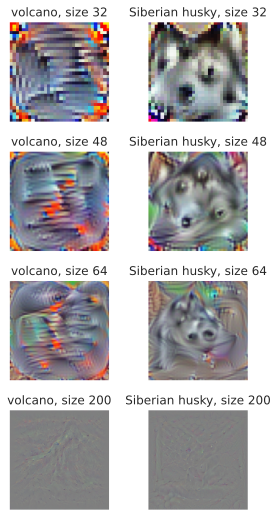

In [73]:
#Code to Show the patches
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            # Check if ax is a single Axes object or an array of Axes
            if len(class_names) == 1 and len(patch_sizes) == 1:
                ax.imshow(patch) # Use ax directly if it's a single Axes
            elif len(class_names) == 1:
                ax[p_idx].imshow(patch) # Index ax with p_idx if there's only one class
            elif len(patch_sizes) == 1:
                ax[c_idx].imshow(patch) # Index ax with c_idx if there's only one patch size
            else:
                ax[p_idx, c_idx].imshow(patch) # Use a single index to access the correct Axes object

            if len(class_names) == 1 and len(patch_sizes) == 1:
                ax.set_title(f"{cname}, size {psize}")
                ax.axis('off')
            elif len(class_names) == 1:
                ax[p_idx].set_title(f"{cname}, size {psize}")
                ax[p_idx].axis('off')
            elif len(patch_sizes) == 1:
                ax[c_idx].set_title(f"{cname}, size {psize}")
                ax[c_idx].axis('off')
            else:
                ax[p_idx, c_idx].set_title(f"{cname}, size {psize}") # Use a single index to access the correct Axes object
                ax[p_idx, c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

In [58]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [59]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [60]:
show_table(top_1=True)

Class name,Patch size 32x32,Patch size 48x48,Patch size 64x64
volcano,0.78%,7.67%,39.88%
Siberian husky,77.32%,87.04%,97.72%


In [61]:
show_table(top_1=False)

Class name,Patch size 32x32,Patch size 48x48,Patch size 64x64
volcano,3.84%,32.79%,66.93%
Siberian husky,93.83%,98.88%,99.89%


In [62]:
#Function to perform the Patch attack
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [64]:

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


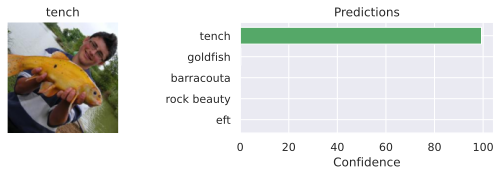

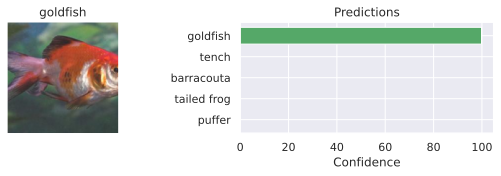

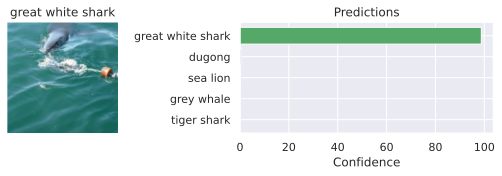

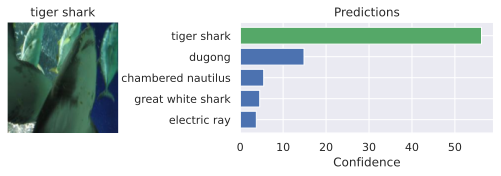

In [74]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

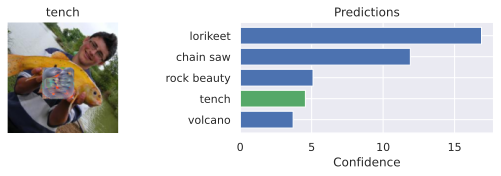

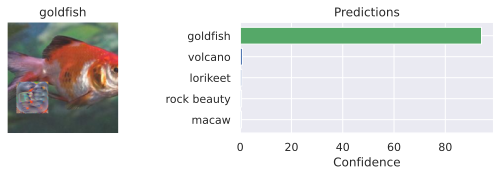

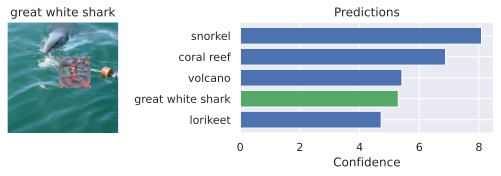

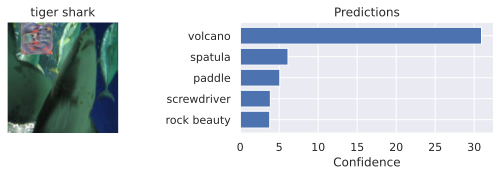

In [67]:
perform_patch_attack(patch_dict['volcano'][64]['patch'])

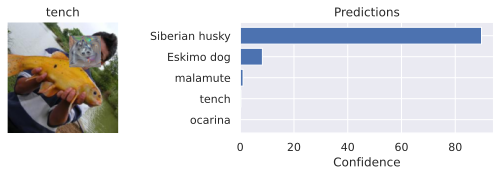

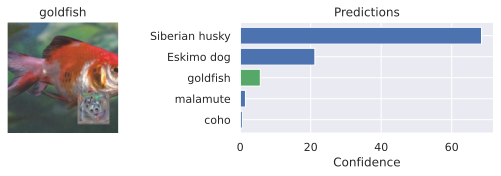

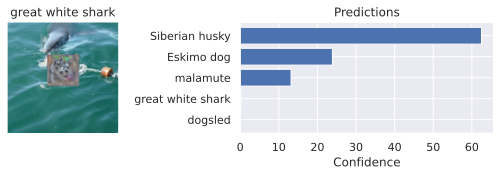

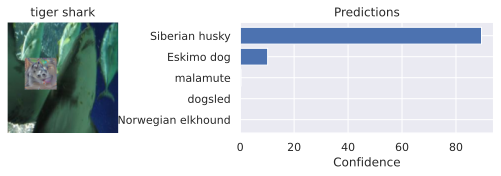

In [76]:
perform_patch_attack(patch_dict['Siberian husky'][64]['patch'])

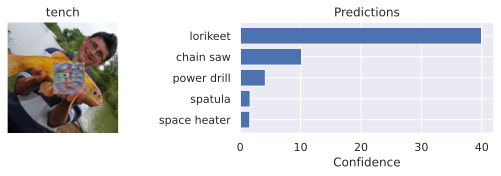

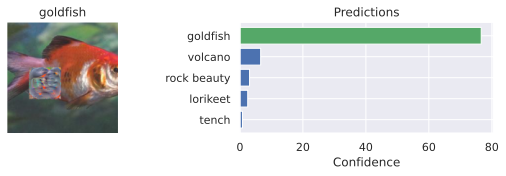

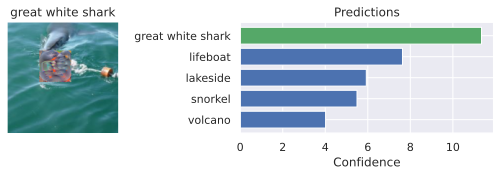

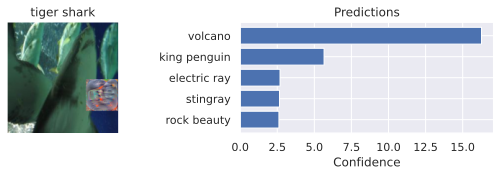

In [55]:
perform_patch_attack(patch_dict['volcano'][64]['patch'])

**Code For Perturbation of an image**

In [1]:
!pip install torch torchvision adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

In [3]:
#Code to obtain the torchvision resnet 34 model with the IMAGENETT1K_V1 weights
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
#Set the model to evaluation mode
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 153MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Set of Functions To classify image**

In [4]:
#Code to load image
def load_image():
    from PIL import Image
    img_volcano = Image.open("volcano.png").convert('RGB')
    print(img_volcano)
    return img_volcano

def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
    img_volcano_preprocessed = preprocess(image)
    batch_img_volcano_tensor = torch.unsqueeze(img_volcano_preprocessed, 0)

    return batch_img_volcano_tensor

def display_pil_image(image, title="Image"):
    # Check if the input is a PIL Image
    if not isinstance(image, Image.Image):
        raise ValueError("Input must be a PIL Image")

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Display the image
    plt.imshow(image)

    # Set the title
    plt.title(title)

    # Remove axis ticks
    plt.axis('off')

    # Show the plot
    plt.show()

def show_image(image):
    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]


    plt.show()

def classify_image(out):
  with open('imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
  #
  # Find the index (tensor) corresponding to the maximum score in the out tensor.
  # Torch.max function can be used to find the information
  #
  _, index = torch.max(out, 1)
  #
  # Find the score in terms of percentage by using torch.nn.functional.softmax function
  # which normalizes the output to range [0,1] and multiplying by 100
  #
  percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
  #
  # Print the name along with score of the object identified by the model
  #
  print(labels[index[0]], percentage[index[0]].item())
  #
  # Print the top 5 scores along with the image label. Sort function is invoked on the torch to sort the scores.
  #
  _, indices = torch.sort(out, descending=True)
  [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]


In [5]:
with open('imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [6]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

def generate_adversarial_image(model, image, true_label, epsilon=0.18):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Convert PIL Image to tensor if necessary
    if isinstance(image, Image.Image):
        transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Adjust size as needed
            transforms.ToTensor(),
        ])
        image = transform(image)

    # Ensure image is a 4D tensor (batch, channels, height, width)
    if image.dim() == 3:
        image = image.unsqueeze(0)

    image = image.to(device)
    true_label = torch.tensor([true_label], dtype=torch.long).to(device)

    classifier = PyTorchClassifier(
        model=model,
        loss=nn.CrossEntropyLoss(),
        input_shape=image.shape[1:],  # Exclude batch dimension
        nb_classes=model.fc.out_features,  # Assuming the last layer is named 'fc'
        device_type=device.type
    )
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)

    # Generate adversarial image
    image_np = image.cpu().numpy()
    adversarial_image_np = attack.generate(x=image_np)

    # Convert back to PyTorch tensor
    adversarial_image = torch.from_numpy(adversarial_image_np).to(device)

    # return adversarial_image.squeeze(0), image.squeeze(0), true_label.item()
    return adversarial_image


In [7]:
def display_image(image_tensor, title="Image"):
    # Check if the image is a PyTorch tensor
    if isinstance(image_tensor, torch.Tensor):
        # Move the tensor to CPU if it's on GPU
        image_tensor = image_tensor.cpu()

        # Remove the batch dimension if it exists
        if image_tensor.dim() == 4:
            image_tensor = image_tensor.squeeze(0)

        # Convert from (C, H, W) to (H, W, C)
        image_tensor = image_tensor.permute(1, 2, 0)

        # Clip values to be between 0 and 1
        image_tensor = torch.clamp(image_tensor, 0, 1)

        # Convert to numpy array
        image_np = image_tensor.numpy()
    else:
        raise ValueError("Input must be a PyTorch tensor")

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_np)
    plt.title(title)
    plt.axis('off')
    plt.show()

<PIL.Image.Image image mode=RGB size=2999x1687 at 0x7B164E72F1F0>


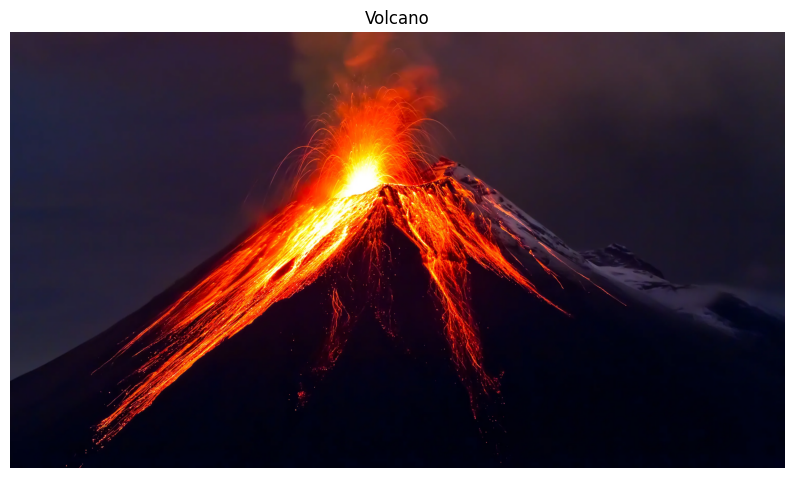

volcano 99.99998474121094


In [8]:
#load the volcano image
img_volcano =  load_image()

#display the image
display_pil_image(img_volcano, "Volcano")
#
volcano_preprocessed = preprocess_image(img_volcano)

out = model(volcano_preprocessed)
# print(out)

classify_image(out)

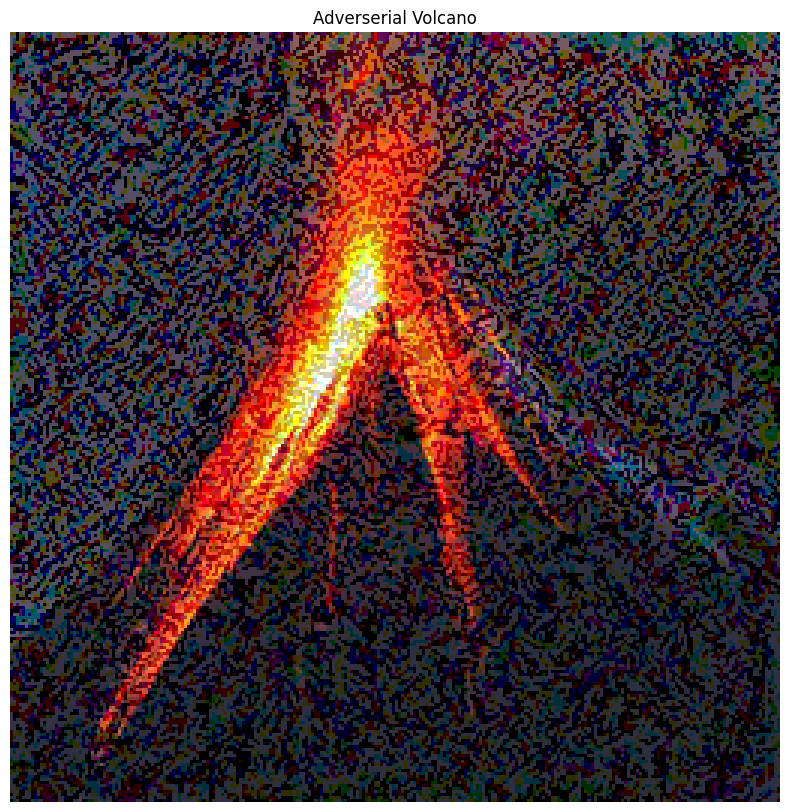

spider web, spider's web 14.7960844039917


In [9]:
#Function call to create an adverserial image using the FGSM method
adverserial_image = generate_adversarial_image(model, img_volcano, 282)
# Function call to display the image
display_image(adverserial_image, "Adverserial Volcano")
# Function call for the model to predict the class of your image
out_adverserial = model(adverserial_image)
# Function call to allign the model Prodictions with the imagenet_classes.txt
classify_image(out_adverserial)